# Preparation

In [1]:
# Install Keras's NLP module first
!pip install -U -q keras-nlp --no-deps

In [2]:
# Set the backend before importing Keras
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
# Import functions first
import PIL
import io
import re
import keras
import keras_nlp
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

2024-08-02 08:36:54.204802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 08:36:54.204933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 08:36:54.339565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
keras.__version__

'3.4.1'

In [5]:
keras_nlp.__version__

'0.14.2'

In [6]:
keras.config.backend()

'jax'

# Define helper functions

In [20]:
# Crop and resize
def crop_and_resize(image, target_size):
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    
    return image.resize(target_size, box=(left, top, right, bottom))

In [21]:
# Image display
def read_image(url, target_size):
    contents = io.BytesIO(requests.get(url).content)
    image = PIL.Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)
    
    if image.shape[2] == 4:
        image = image[:, :, :3]
    
    return image

In [22]:
# Parse frame and labels
def parse_bbox_and_labels(detokenized_output: str):
    matches = re.finditer(
        "<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>"
        " (?P<label>.+?)( ;|$)",
    detokenized_output
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d["y0"]), fmt(d["x0"]), fmt(d["y1"]), fmt(d["x1"])])
        labels.append(d["label"])
    
    return np.array(boxes), np.array(labels)

In [23]:
# Frame display
def display_boxes(image, boxes, labels, target_image_size):
    h, l = target_size
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * h
        width = x2 - x
        height = y2 - y
        rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=1,
            edgecolor="b",
            facecolor="none"
        )
        plt.text(x, y, labels[i], color="blue", fontsize=12)
        ax.add_patch(rect)
    
    plt.show()

# Model application

In [24]:
keras.config.set_floatx("bfloat16")

In [25]:
pali_gemma_lm = keras_nlp.models.PaliGemmaCausalLM.from_preset("pali_gemma_3b_mix_224")

Attaching 'model.safetensors' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3

In [26]:
pali_gemma_lm.summary()

Preprocessor: "pali_gemma_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)          │                                             257,152 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "pali_gemma_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,923,335,408 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,923,335,408 (5.45 GB)

 Trainable params: 2,923,335,408 (5.45 GB)

 Non-trainable params: 0 (0.00 B)

# Inference testing

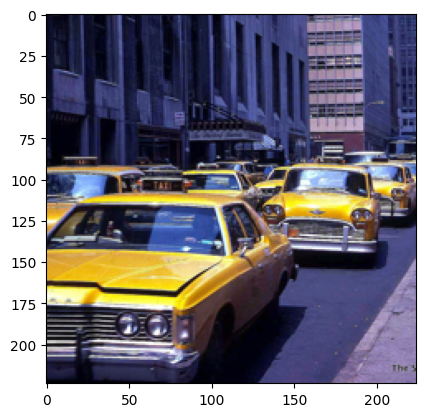

In [30]:
# Crop the image within the approximate dimensions
target_size = (224, 224)
image_url = 'https://i0.wp.com/www.curbsideclassic.com/wp-content/uploads/2018/10/NYC-taxis-1974.jpg'
image = read_image(image_url, target_size)
plt.imshow(image)

In [31]:
# Prompt call
prompt = 'answer en where are the taxis parked?\n'
output = pali_gemma_lm.generate(
    inputs={
        "images": image,
        "prompts": prompt
    }
)

print(output)

answer en where are the taxis parked?
street


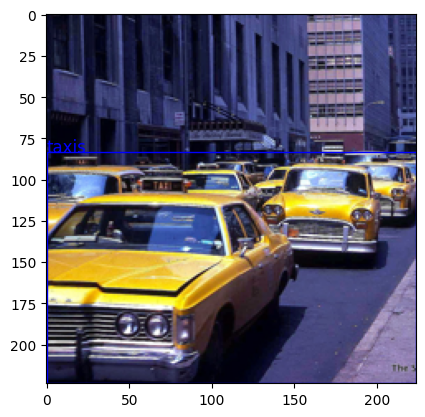

In [32]:
# Object detection
prompt = 'detect taxis\n'
output = pali_gemma_lm.generate(
    inputs={
        "images": image,
        "prompts": prompt
    }
)

boxes, labels = parse_bbox_and_labels(output)
display_boxes(image, boxes, labels, target_size)

In [35]:
# Batched inputs
prompts = [
    'answer en where are the taxis parked?\n',
    'answer en what color of the taxis?\n',
    'describe en\n',
    'detect taxis\n',
    'segment taxis\n'
]
images = [image, image, image, image, image]
outputs = pali_gemma_lm.generate(
    inputs={
        "images": images,
        "prompts": prompts
    }
)

for output in outputs:
    print(output)

answer en where are the taxis parked?
street
answer en what color of the taxis?
yellow
describe en
In this image we can see many vehicles on the road. In the background, we can see buildings and a board.
detect taxis
<loc0382><loc0000><loc1022><loc1022> taxis
segment taxis
<loc0409><loc0000><loc1023><loc0690><seg035><seg084><seg041><seg031><seg038><seg056><seg023><seg023><seg042><seg090><seg069><seg056><seg035><seg000><seg012><seg099>
